In [101]:
import re
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import keras
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import math
import nltk

In [102]:
# Read data

df = pd.read_csv('sentiment.csv')
df.head()

,id,candidate,candidate_confidence,relevant_yn,relevant_yn_confidence,sentiment,sentiment_confidence,subject_matter,subject_matter_confidence,candidate_gold,...,relevant_yn_gold,retweet_count,sentiment_gold,subject_matter_gold,text,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone
0,1,No candidate mentioned,1.0,yes,1.0,Neutral,0.6578,None of the above,1.0000,NaN,...,NaN,5,NaN,NaN,RT @NancyLeeGrahn: How did everyone feel about...,NaN,2015-08-07 09:54:46 -0700,629697200650592256,NaN,Quito
1,2,Scott Walker,1.0,yes,1.0,Positive,0.6333,None of the above,1.0000,NaN,...,NaN,26,NaN,NaN,RT @ScottWalker: Didn't catch the full #GOPdeb...,NaN,2015-08-07 09:54:46 -0700,629697199560069120,NaN,NaN
2,3,No candidate mentioned,1.0,yes,1.0,Neutral,0.6629,None of the above,0.6629,NaN,...,NaN,27,NaN,NaN,RT @TJMShow: No mention of Tamir Rice and the ...,NaN,2015-08-07 09:54:46 -0700,629697199312482304,NaN,NaN
3,4,No candidate mentioned,1.0,yes,1.0,Positive,1.0000,None of the above,0.7039,NaN,...,NaN,138,NaN,NaN,RT @RobGeorge: That Carly Fiorina is trending ...,NaN,2015-08-07 09:54:45 -0700,629697197118861312,Texas,Central Time (US & Canada)
4,5,Donald Trump,1.0,yes,1.0,Positive,0.7045,None of the above,1.0000,NaN,...,NaN,156,NaN,NaN,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,NaN,2015-08-07 09:54:45 -0700,629697196967903232,NaN,Arizona


In [103]:
# Explore the data

df.shape

(13871, 21)

In [104]:
df.describe()

,id,candidate_confidence,relevant_yn_confidence,sentiment_confidence,subject_matter_confidence,retweet_count,tweet_id
count,13871.000000,13871.000000,13871.000000,13871.000000,13871.000000,13871.000000,1.387100e+04
mean,6936.000000,0.855689,0.927304,0.756936,0.782801,45.803331,6.296058e+17
std,4004.357127,0.241388,0.141696,0.217682,0.258215,153.981724,9.611863e+13
min,1.000000,0.222200,0.333300,0.186000,0.222200,0.000000,6.294531e+17
25%,3468.500000,0.674200,1.000000,0.651700,0.641300,0.000000,6.294861e+17
50%,6936.000000,1.000000,1.000000,0.681300,1.000000,2.000000,6.296726e+17
75%,10403.500000,1.000000,1.000000,1.000000,1.000000,44.000000,6.296882e+17
max,13871.000000,1.000000,1.000000,1.000000,1.000000,4965.000000,6.297017e+17


In [105]:
# DataTypes of columns
df.dtypes

id                             int64
candidate                     object
candidate_confidence         float64
relevant_yn                   object
relevant_yn_confidence       float64
sentiment                     object
sentiment_confidence         float64
subject_matter                object
subject_matter_confidence    float64
candidate_gold                object
name                          object
relevant_yn_gold              object
retweet_count                  int64
sentiment_gold                object
subject_matter_gold           object
text                          object
tweet_coord                   object
tweet_created                 object
tweet_id                       int64
tweet_location                object
user_timezone                 object
dtype: object

In [106]:
# displaying categorical and numerical variables

cat_cols = list(df.select_dtypes(include = ['object']))
print(f'categrical columns: {cat_cols}')

num_cols = list(df.select_dtypes(exclude = ['object']))
print(f'numerical columns: {num_cols}')

categrical columns: ['candidate', 'relevant_yn', 'sentiment', 'subject_matter', 'candidate_gold', 'name', 'relevant_yn_gold', 'sentiment_gold', 'subject_matter_gold', 'text', 'tweet_coord', 'tweet_created', 'tweet_location', 'user_timezone']
numerical columns: ['id', 'candidate_confidence', 'relevant_yn_confidence', 'sentiment_confidence', 'subject_matter_confidence', 'retweet_count', 'tweet_id']


In [107]:
# Checking for missing values

df.isnull().sum()

id                               0
candidate                       96
candidate_confidence             0
relevant_yn                      0
relevant_yn_confidence           0
sentiment                        0
sentiment_confidence             0
subject_matter                 326
subject_matter_confidence        0
candidate_gold               13843
name                             0
relevant_yn_gold             13839
retweet_count                    0
sentiment_gold               13856
subject_matter_gold          13853
text                             0
tweet_coord                  13850
tweet_created                    0
tweet_id                         0
tweet_location                3912
user_timezone                 4403
dtype: int64

In [108]:
# List of missing columns:

missing = [miss for miss in df.columns if df[miss].isnull().sum() > 0]
print(missing)

['candidate', 'subject_matter', 'candidate_gold', 'relevant_yn_gold', 'sentiment_gold', 'subject_matter_gold', 'tweet_coord', 'tweet_location', 'user_timezone']


<AxesSubplot:>

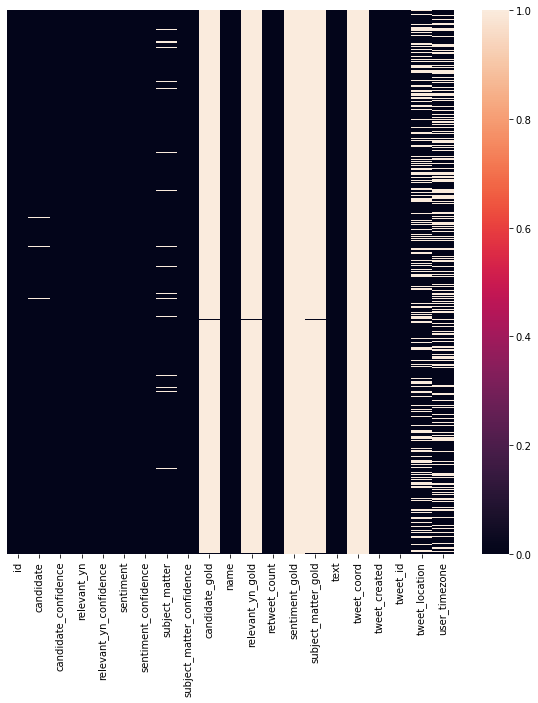

In [109]:
# visualizing missing values

plt.figure(figsize = (10,10))
sns.heatmap(df.isna(), yticklabels = False)

In [110]:
# Dropping major missing columns:

for i in missing:
    if df[i].isnull().sum() > 10000:
        df.drop(i, axis = 1, inplace = True)

In [111]:
# List of missing columns after removing major missing value columns:

missing = [miss for miss in df.columns if df[miss].isnull().sum() > 0]
print(missing)

['candidate', 'subject_matter', 'tweet_location', 'user_timezone']


<AxesSubplot:>

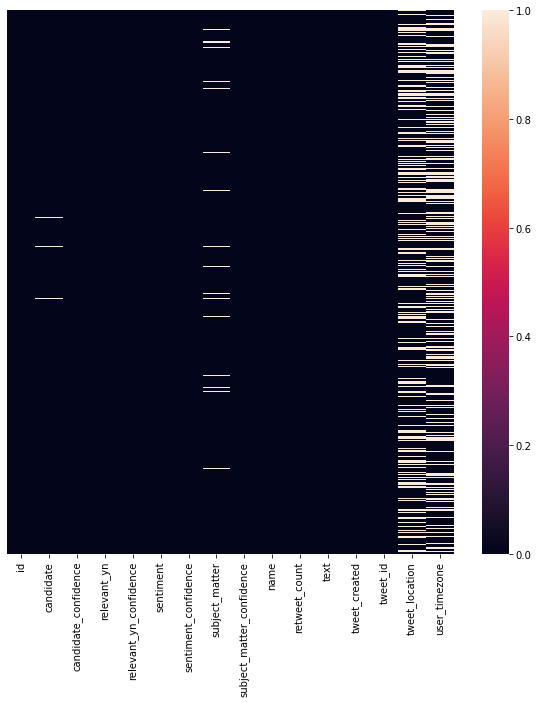

In [112]:
# visualizing missing values after removing major missing value columns:

plt.figure(figsize = (10,10))
sns.heatmap(df.isna(), yticklabels = False)

# Question 1  

### Print the total number of positive and negative sentiments.

In [113]:
print('Total Number positive and negative Sentiments :',len(df[df['sentiment'] == 'Positive']) + len(df[df['sentiment'] == 'Negative']))

Total Number positive and negative Sentiments : 10729


In [114]:
df_new = df[["sentiment", "text"]]
df_new.head()

,sentiment,text
0,Neutral,RT @NancyLeeGrahn: How did everyone feel about...
1,Positive,RT @ScottWalker: Didn't catch the full #GOPdeb...
2,Neutral,RT @TJMShow: No mention of Tamir Rice and the ...
3,Positive,RT @RobGeorge: That Carly Fiorina is trending ...
4,Positive,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...


In [115]:
# Removing stopwords
stop_words = set(stopwords.words('english'))
df_new['text'] = df_new['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

C:\Users\AMBARE~1.K\AppData\Local\Temp/ipykernel_3444/1524829681.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['text'] = df_new['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))


In [116]:
# Lemmatizing text
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()
def lemmatize_text(text):
    st = ""
    for w in w_tokenizer.tokenize(text):
        st = st + lemmatizer.lemmatize(w) + " "
    return st
df_new['text'] = df_new.text.apply(lemmatize_text)
df_new.sample(15)

C:\Users\AMBARE~1.K\AppData\Local\Temp/ipykernel_3444/4218381602.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['text'] = df_new.text.apply(lemmatize_text)


,sentiment,text
6637,Neutral,Didn't get watch last night's #GOPDebate sound...
8120,Positive,"RT @RWSurferGirl: Trump got right, nobody woul..."
11401,Negative,RT @ccabrera83: Jeb Bush lied. And poorly. #GO...
9701,Negative,RT @SupermanHotMale: I lived Florida 8 year Je...
4882,Negative,MT What I learned last night talking head lot ...
8826,Positive,RT @b140tweet: Rip #AnnRichards... She right.....
6270,Negative,RT @DANEgerus: I expect Chris Wallace(D) 2nd w...
3174,Negative,"http://t.co/OvG0auASYi... oh my, really? y'all..."
7053,Negative,GOP Debate News - Trump Shocks GOP Faithful - ...
3743,Negative,RT @inthequeencity: Politicians even pretendin...


In [117]:
# Encoding Labels
reviews = df_new["text"].values
labels = df_new["sentiment"].values
encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(labels)

In [118]:
# Train Test Split
train_sentences, test_sentences, train_labels, test_labels = train_test_split(reviews, encoded_labels, stratify = encoded_labels)

In [119]:
# Tokenizing Sentences
vocab_size = 3000 
oov_tok = ''
embedding_dim = 100
max_length = 200 
padding_type='post'
trunc_type='post'

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index
train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_sequences, padding='post', maxlen=max_length)

test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_padded = pad_sequences(test_sequences, padding='post', maxlen=max_length)

In [120]:
model = keras.Sequential([
    keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    keras.layers.Bidirectional(keras.layers.LSTM(64)),
    keras.layers.Dense(24, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])
# compile model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
# model summary
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 200, 100)          300000    
                                                                 
 bidirectional_4 (Bidirectio  (None, 128)              84480     
 nal)                                                            
                                                                 
 dense_8 (Dense)             (None, 24)                3096      
                                                                 
 dense_9 (Dense)             (None, 1)                 25        
                                                                 
Total params: 387,601
Trainable params: 387,601
Non-trainable params: 0
_________________________________________________________________


In [121]:
num_epochs = 5
history = model.fit(train_padded, train_labels, 
                    epochs=num_epochs, verbose=1, 
                    validation_split=0.1)

Epoch 1/5
293/293 [==============================] - 89s 291ms/step - loss: 1.7271 - accuracy: 0.4316 - val_loss: 0.6293 - val_accuracy: 0.3256
Epoch 2/5
293/293 [==============================] - 79s 269ms/step - loss: 0.3137 - accuracy: 0.5657 - val_loss: 0.1922 - val_accuracy: 0.5716
Epoch 3/5
293/293 [==============================] - 75s 255ms/step - loss: 0.4470 - accuracy: 0.5749 - val_loss: 0.1590 - val_accuracy: 0.5639
Epoch 4/5
293/293 [==============================] - 80s 272ms/step - loss: -1.6447 - accuracy: 0.6015 - val_loss: -1.0721 - val_accuracy: 0.4966
Epoch 5/5
293/293 [==============================] - 79s 269ms/step - loss: -9.9548 - accuracy: 0.5759 - val_loss: -4.9029 - val_accuracy: 0.5706


In [124]:
prediction = model.predict(test_padded)
pred_labels = []
for i in prediction:
    if i >= 0.66:
        pred_labels.append(1)
    elif  i < 0.66 and i >= 0.33:
        pred_labels.append(0)
    else:
        pred_labels.append(-1)

In [123]:
sentence = ["He is a great leader.", 
            "He is a terrible leader."]

sequences = tokenizer.texts_to_sequences(sentence)

padded = pad_sequences(sequences, padding='post', maxlen=max_length)
prediction = model.predict(padded)
pred_labels = []

for i in prediction:
    if i >= 0.66:
        pred_labels.append(1)
    elif  i < 0.66 and i >= 0.33:
        pred_labels.append(0)
    else:
        pred_labels.append(-1)
        
for i in range(len(sentence)):
    print(sentence[i])
    if pred_labels[i] == 1:
        s = 'Positive'
    elif pred_labels[i] == 0:
        s = "Neutral"
    else:
        s = 'Negative'
    print("Predicted sentiment : ",s)

He is a great leader.
Predicted sentiment :  Positive
He is a terrible leader.
Predicted sentiment :  Negative
